In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta as ta
import os
import datetime
import json
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbtpro as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from donchian_ma import get_data,Strategy

### 樣本內全參數 (多、空)

In [2]:
import ast
import pandas as pd
import hiplot as hip

def insample_params_highland(coin:str, freq: str, direction: str):
    params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
    params_df['params'] = params_df['params'].apply(ast.literal_eval)
    temp_df = params_df['params'].apply(pd.Series)
    df = pd.concat([params_df.drop(columns='params'), temp_df], axis=1)
    target = df[['window_l_k','window_l_d','window_s_k','window_s_d','Sharpe Ratio','Calmar Ratio','Win Rate [%]']]
    data_for_hiplot = target.to_dict(orient='records')
    exp = hip.Experiment.from_iterable(data_for_hiplot)
    exp.display(force_full_width=False, width=400, height=100)


In [1]:
import pandas as pd
import json

symbol_list = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               '1000PEPE','LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR','STORJ',
               '1000FLOKI','MKR','CYBER','UNI','STRAX',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']

params_dict = {}
for freq in ['5T','15T','1h','4h']:
    params_dict[freq] = {}
    for coin in symbol_list:
        params_dict[freq][coin] = {}
        for direction in ['long','short']:
            params_dict[freq][coin][direction] = {}
            i = 0
            try:
                params_df = pd.read_csv(f'opt/{freq}/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
                for _ , row in params_df[params_df['Sharpe Ratio']>2].iterrows():
                    params_dict[freq][coin][direction][str(i)] = row['params']
                    i += 1
            except Exception as e:
                pass
        try:
            if len(params_dict[freq][coin]['long'])==0 or len(params_dict[freq][coin]['short']==0):
                params_dict[freq].pop(coin)
        except:
            pass
            
filename = "params.json"

with open(filename, 'w') as file:
    json.dump(params_dict, file, indent=4)

### 樣本外
取樣本內前一半參數來看樣本外表現


In [4]:
df_dict = {}
candidate = ['ETH','BTC','BNB','SOL','MATIC',
               'XRP','DYDX','AVAX','LINK','GAS',
               'DOGE','ORDI','TRB','WLD','ADA',
               'OP','FIL','ZRX','LTC','RUNE','ATOM',
               'ARB','GMT','ETC','ARK','BCH','DOT',
               'LDO','SUI','GALA','CAKE',
               'APE','INJ','FTM','APT','YFI','OMG',
               'SEI','EOS','1000SHIB','NEAR',
               'MKR','CYBER','UNI',
               'BLUR','SUSHI','WAVES','MASK','MANA',
               'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']

for coin in candidate:
    df_dict[coin] = pd.read_hdf(f'/Users/johnsonhsiao/Desktop/data/{coin}USDT_PERPETUAL.h5')


In [5]:
from tqdm.auto import tqdm
start = '2022-01-01'
sep = ''
end = ''

def outample_params_highland(freq, side, coin):
    outsample_record = []
    params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/bband/opt/{freq}/{coin}/{direction}_record_df.csv')
    for idx , row in tqdm(params_df[:int(len(params_df)/2)].iterrows(), total=int(len(params_df)/2), desc="Processing"):
        params = eval(row['params'])
        config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
        df = df_dict[coin]
        strategy = Strategy(df=df.loc[start:], configs=config)
        analyze = Analyzer(strategy)
        mdd, stat = analyze.outsample_result_gen(params, side, coin, axv_index=['2023-05-01'])
        params['mdd'] = mdd
        params['sharpe'] = stat['Sharpe Ratio']
        params['calmar'] = stat['Calmar Ratio']
        params['win rate'] = stat['Win Rate [%]']
        outsample_record.append(params)
    exp = hip.Experiment.from_iterable(outsample_record)
    exp.display()


In [16]:
def in_out_test(freq, coin):
    for direction in ['long','short']:
        outsample_record = []
        params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/donchian_ma/opt/{freq}/{coin}/{direction}_record_df.csv')
        for idx , row in tqdm(params_df[:int(len(params_df)/25)].iterrows(), total=int(len(params_df)/25), desc="Processing"):
            params = eval(row['params'])
            config = {'freq':freq, 'lag':1, 'fee': 0.0003, 'weekend_filter': False}
            try:
                df = df_dict[coin]
            except:
                df_dict[coin] = pd.read_hdf(f'/Volumes/crypto_data/price_data/binance/1m/{coin}USDT_PERPETUAL.h5')
                df = df_dict[coin]            
            strategy = Strategy(df=df.loc[start:], configs=config)
            analyze = Analyzer(strategy)
            mdd, stat = analyze.outsample_result_gen(params, direction, coin, axv_index=['2023-05-01'])
            params['mdd'] = mdd
            params['sharpe'] = stat['Sharpe Ratio']
            params['calmar'] = stat['Calmar Ratio']
            params['win rate'] = stat['Win Rate [%]']
            outsample_record.append(params)
        max_sharpe = 0
        for i in range(len(outsample_record)):
            if outsample_record[i]['sharpe'] > max_sharpe:
                max_sharpe = outsample_record[i]['sharpe']
                best_params = outsample_record[i]
        if max_sharpe > 2:
            print(best_params)
            strategy = Strategy(df=df.loc[start:], configs=config)
            analyze = Analyzer(strategy)
            analyze.show_pf_analysis(dict(list(best_params.items())[:3]), direction, coin, axv_index=['2023-05-01'])

In [19]:
for freq in insample_long_dict.keys():
    for coin in insample_long_dict[freq]:
        print(coin, freq)
        in_out_test(freq,coin)

OP 5T


Processing:   0%|          | 0/163 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 挑選參數全樣本結果

APY: -5.28 %
MDD: 45.62 %
MDD Duration 520 days 04:00:00
worst trade: -14.93 %
2022-07-12 19:00:00 ~ 2022-07-14 17:00:00
avg holding days: 5.89 days
--------------------------------------------
PF: 0.95
Sharpe Ratio: 0.14
Calmar Ratio: -0.12
Sortino Ratio: 0.20
Omega Ratio: 1.01
--------------------------------------------
Expectancy : -0.14 %
Total Time Exposure : 61.54 %
Total Trades: 72
Win Rate: 30.56 %
--------------------------------------------
PF * Win Rate: 0.291


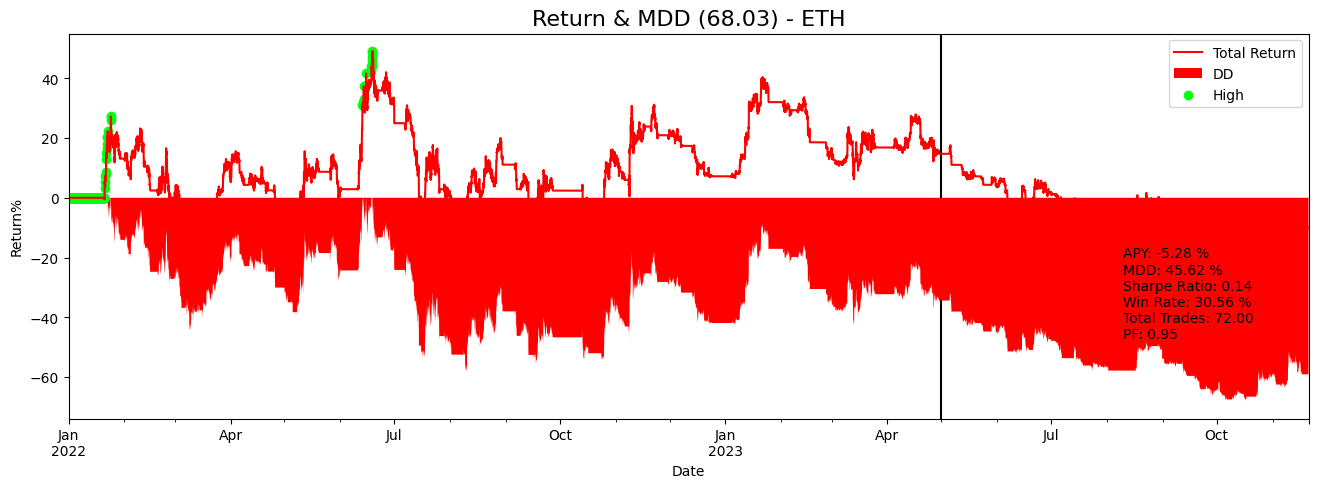

(None,
 Start                                2022-01-01 00:00:00
 End                                  2023-11-21 00:00:00
 Period                                 689 days 01:00:00
 Start Value                                      10000.0
 Min Value                                    8108.545676
 Max Value                                   14911.283228
 End Value                                    9002.432493
 Total Return [%]                               -9.975675
 Benchmark Return [%]                          -45.658535
 Total Time Exposure [%]                        61.540787
 Max Gross Exposure [%]                        117.694929
 Max Drawdown [%]                               45.621409
 Max Drawdown Duration                  520 days 04:00:00
 Total Orders                                         140
 Total Fees Paid                                418.65982
 Total Trades                                          72
 Win Rate [%]                                   30.555556
 Best T

In [10]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'

params = {'uchannel': 130, 'lchannel': 205, 'ma_window': 190}
# sol 1h : 40,48,100,126,95 original
config = {'freq':'1h', 'lag':1, 'fee': 0.0003,'weekend_filter':False}
coin = 'ETH'
df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])